In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [2]:
cwd = os.getcwd()
test_images_dir = os.path.join(cwd, "data/test_images")

img_h, img_w = 540, 960

In [3]:
def plot_images(images):
    fig, axes = plt.subplots(3, 2, figsize=(20, 18))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].astype(np.uint8))
        ax.set_yticks([])
        ax.set_xticks([])

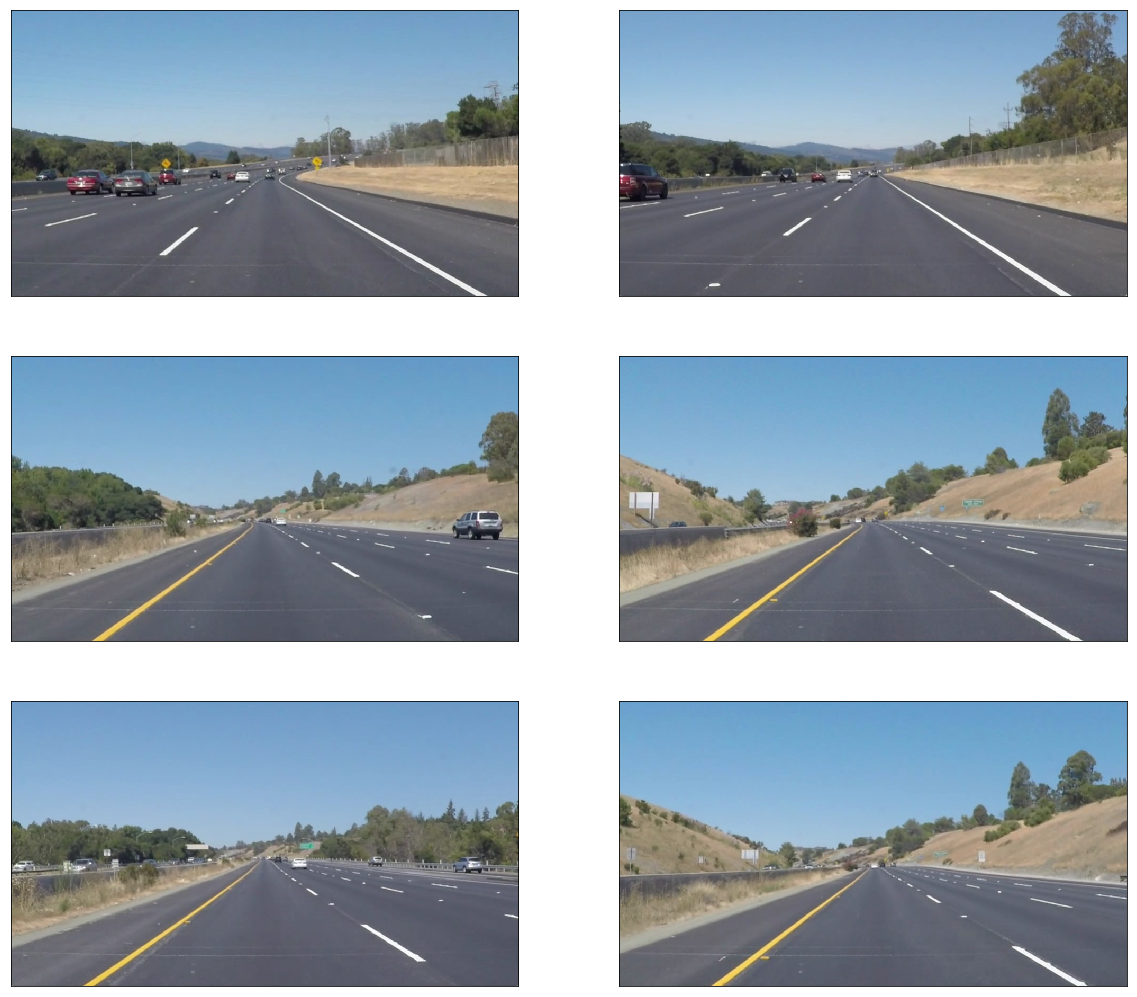

In [4]:
test_images = [cv2.cvtColor(cv2.imread(os.path.join(test_images_dir, img)), cv2.COLOR_BGR2RGB) for img in os.listdir(test_images_dir)]
plot_images(test_images)

In [5]:
test_images[0].shape

(540, 960, 3)

In [6]:
class Line:
    def __init__(self, x1, y1, x2, y2):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
        
        self.slope = self.line_slope()
        self.intercept = self.line_intercept()
        self.is_slope_positive = True if self.slope > 0 else False
        
    def line_slope(self):
        m = (self.y2-self.y1) / (self.x2-self.x1 + np.finfo(float).eps)
        return m
        
    def line_intercept(self):
        b = self.y1 - (self.slope*self.x1)
        return b
    
    def get_line_coordinates(self):
        return np.array([self.x1, self.y1, self.x2, self.y2])
    def set_line_coordinates(self, x1, y1, x2, y2):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2

def draw_lines(img, lane):
    x1, y1, x2, y2 = lane.get_line_coordinates()
    cv2.line(img, (x1, y1), (x2, y2), color=[255, 0, 0], thickness=10)
    
    return img

def make_object(lines):
    detected_lines = []
    for line in lines:
        l = Line(line[0][0], line[0][1], line[0][2], line[0][3])
        if 0.5 <= np.abs(l.slope) <= 2:
            detected_lines.append(l)
    return detected_lines

def compute_pos_neg_lines(detected_lines):
    positive_lines, negative_lines = [], []
    for line in detected_lines:
        if line.is_slope_positive:
            positive_lines.append(line)
        else:
            negative_lines.append(line)
    return positive_lines, negative_lines

def compute_left_lane(negative_lines):
    negative_intercept = np.median([line.intercept for line in negative_lines]).astype(int)
    negative_slope = np.median([line.slope for line in negative_lines])
    x1, y1 = 0, negative_intercept
    x2, y2 = np.round(-negative_intercept/ negative_slope).astype(int), 0
    left_lane = Line(x1, y1, x2, y2)
    return left_lane

def compute_right_lane(positive_lines):
    positive_intercept = np.median([line.intercept for line in positive_lines]).astype(int)
    positive_slope = np.median([line.slope for line in positive_lines])
    x1, y1 = 0, positive_intercept
    x2, y2 = np.round((img_h - positive_intercept)/positive_slope).astype(int), img_h
    right_lane = Line(x1, y1, x2, y2)
    return right_lane
    
def compute_lanes(detected_lines):
    positive_lines, negative_lines = compute_pos_neg_lines(detected_lines)
    left_lane = compute_left_lane(negative_lines)
    right_lane = compute_right_lane(positive_lines)
    return left_lane, right_lane

def detect_lanes(img):
    img = cv2.resize(img, (img_w, img_h))
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    img_blur = cv2.GaussianBlur(img_gray, (11, 19), 3)

    img_edge = cv2.Canny(img_blur, threshold1=50, threshold2=75)
    
    lines = cv2.HoughLinesP(img_edge, rho=1, theta=np.pi/180, threshold=1, lines=np.array([]), minLineLength=15,maxLineGap=5)
    
    detected_lines = make_object(lines)
    left_lane, right_lane = compute_lanes(detected_lines)
    return left_lane, right_lane

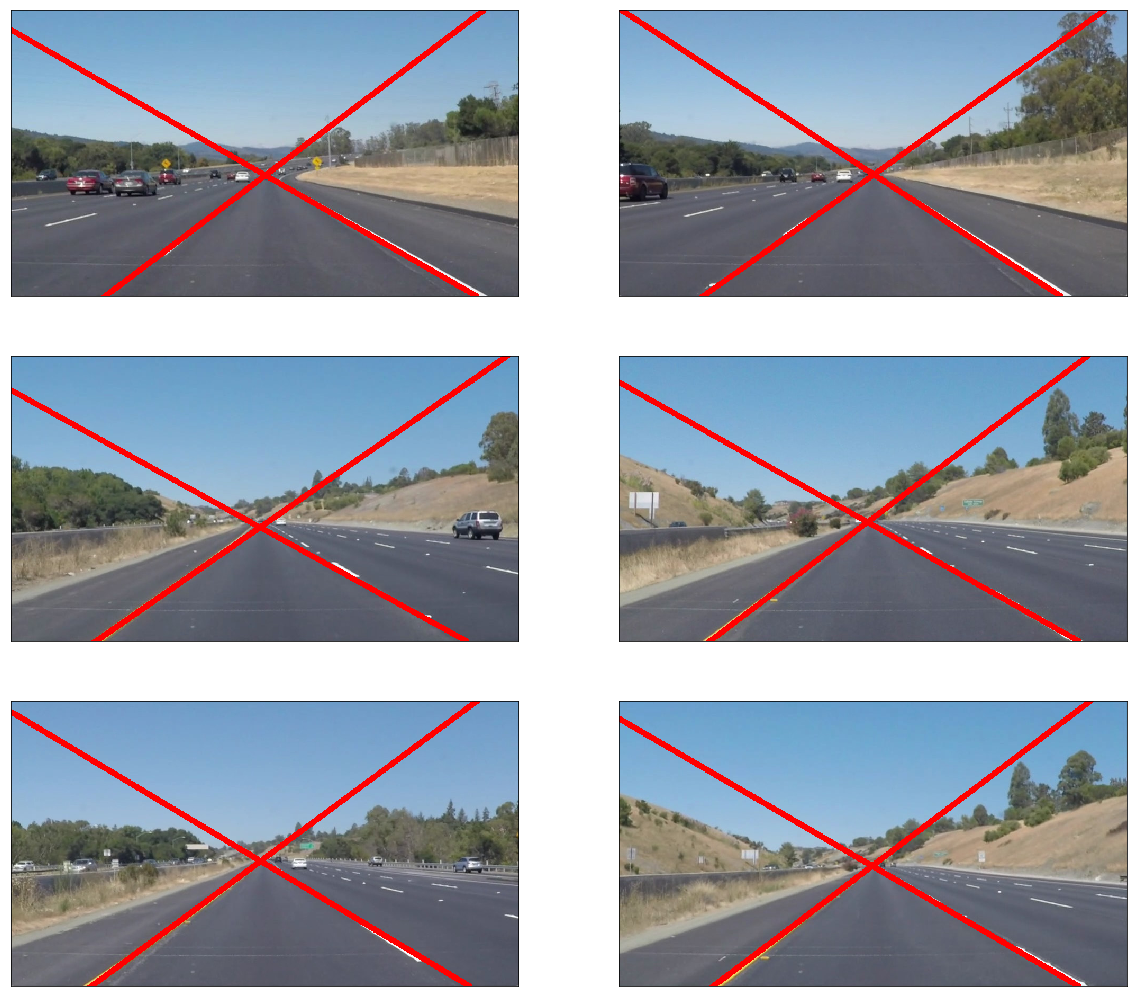

In [7]:
lanes = [detect_lanes(img) for img in test_images]
test_images_with_lanes = []
for i, lane in enumerate(lanes):
    left, right = lane
    img = draw_lines(test_images[i], left)
    img = draw_lines(img, right)
    test_images_with_lanes.append(img)
plot_images(test_images_with_lanes)

In [8]:
def get_region_of_interest(lane, vertices):
    left, right = lane
    
    img_zeros = np.zeros(shape=[img_h, img_w, 3])
    img_zeros = draw_lines(img_zeros, left)
    img_zeros = draw_lines(img_zeros, right)
    
    mask = np.zeros_like(img_zeros)
    if len(img_zeros.shape) > 2:
        mask_color = (255, ) * img.shape[2]
    else:
        mask_color = 255
    mask = cv2.fillPoly(mask, vertices, mask_color)
    masked_image = cv2.bitwise_and(img_zeros, mask)
    
    return mask, masked_image

In [9]:
vertices = np.array([[(50, img_h),
                          (450, 310),
                          (490, 310),
                          (img_w - 50, img_h)]],
                        dtype=np.int32)

In [10]:
masks, masked_images = [], []

for i, lane in enumerate(lanes):
    mask, masked_image = get_region_of_interest(lane, vertices)
    masks.append(mask)
    masked_images.append(masked_image)

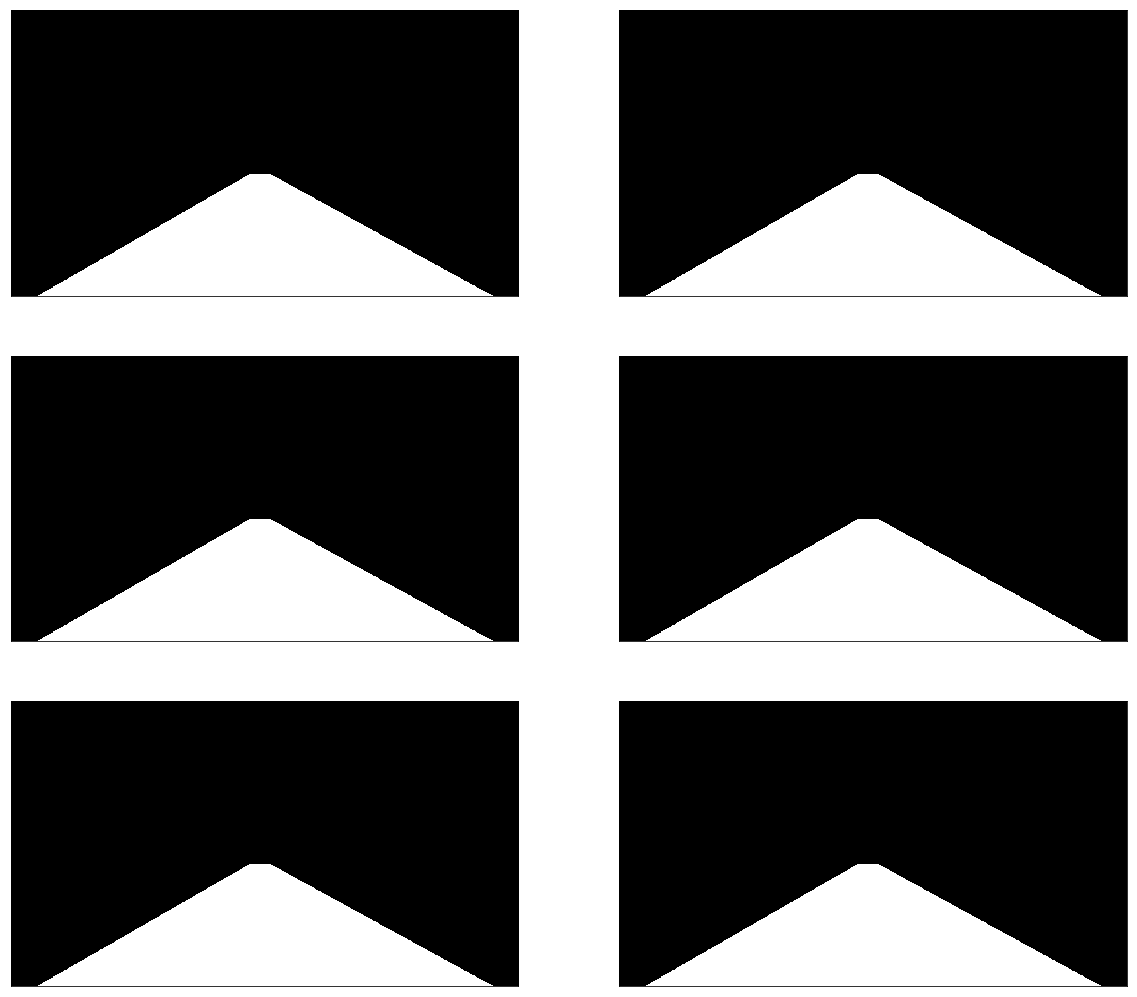

In [11]:
plot_images(masks)

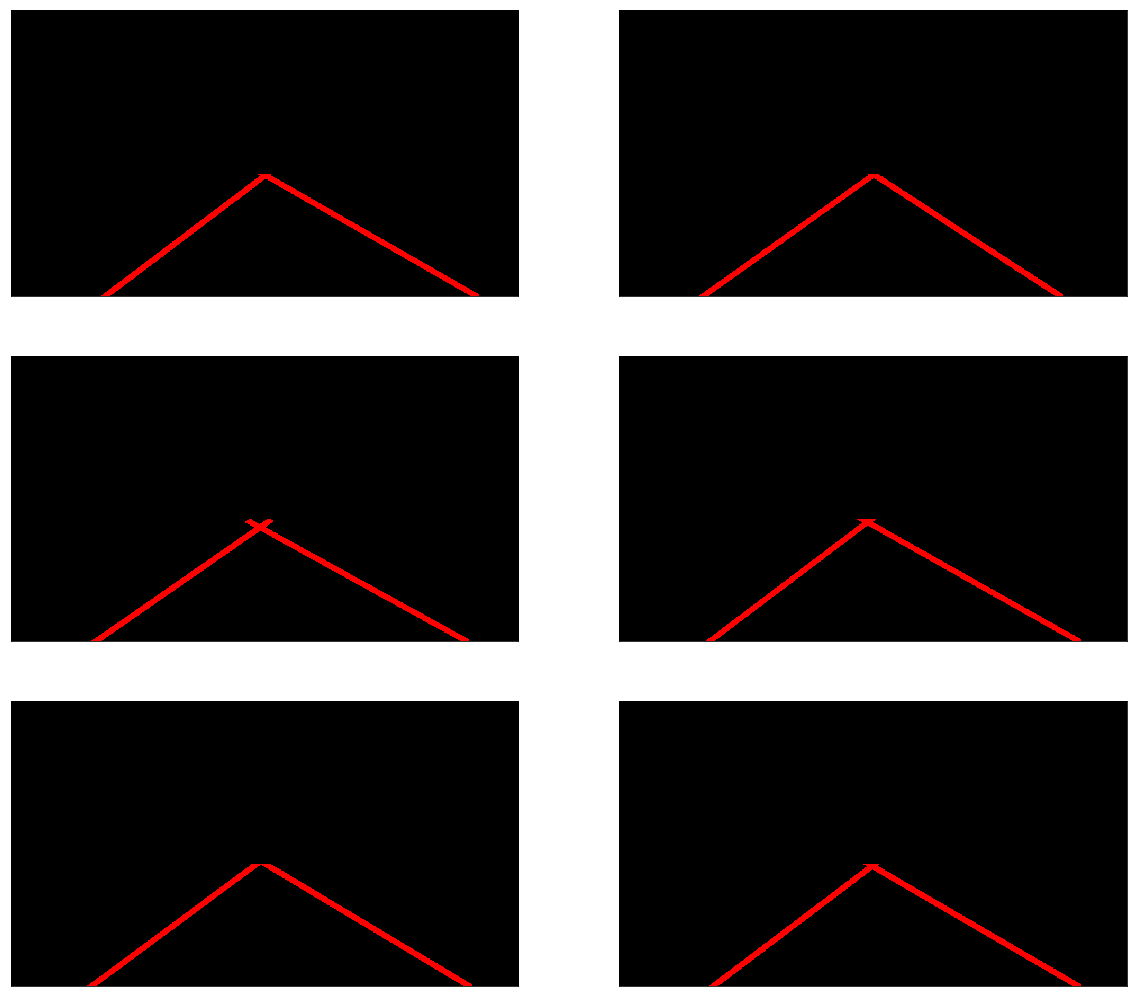

In [12]:
plot_images(masked_images)

In [13]:
def draw_lanes(img, masked_img):
    masked_img = np.uint8(masked_img)
    return cv2.addWeighted(img, 0.8, masked_img, 1.0, 0.0)

In [14]:
test_images = [cv2.cvtColor(cv2.imread(os.path.join(test_images_dir, img)), cv2.COLOR_BGR2RGB) for img in os.listdir(test_images_dir)]
output_images = [draw_lanes(test_images[i], masked_images[i]) for i in range(len(test_images))]

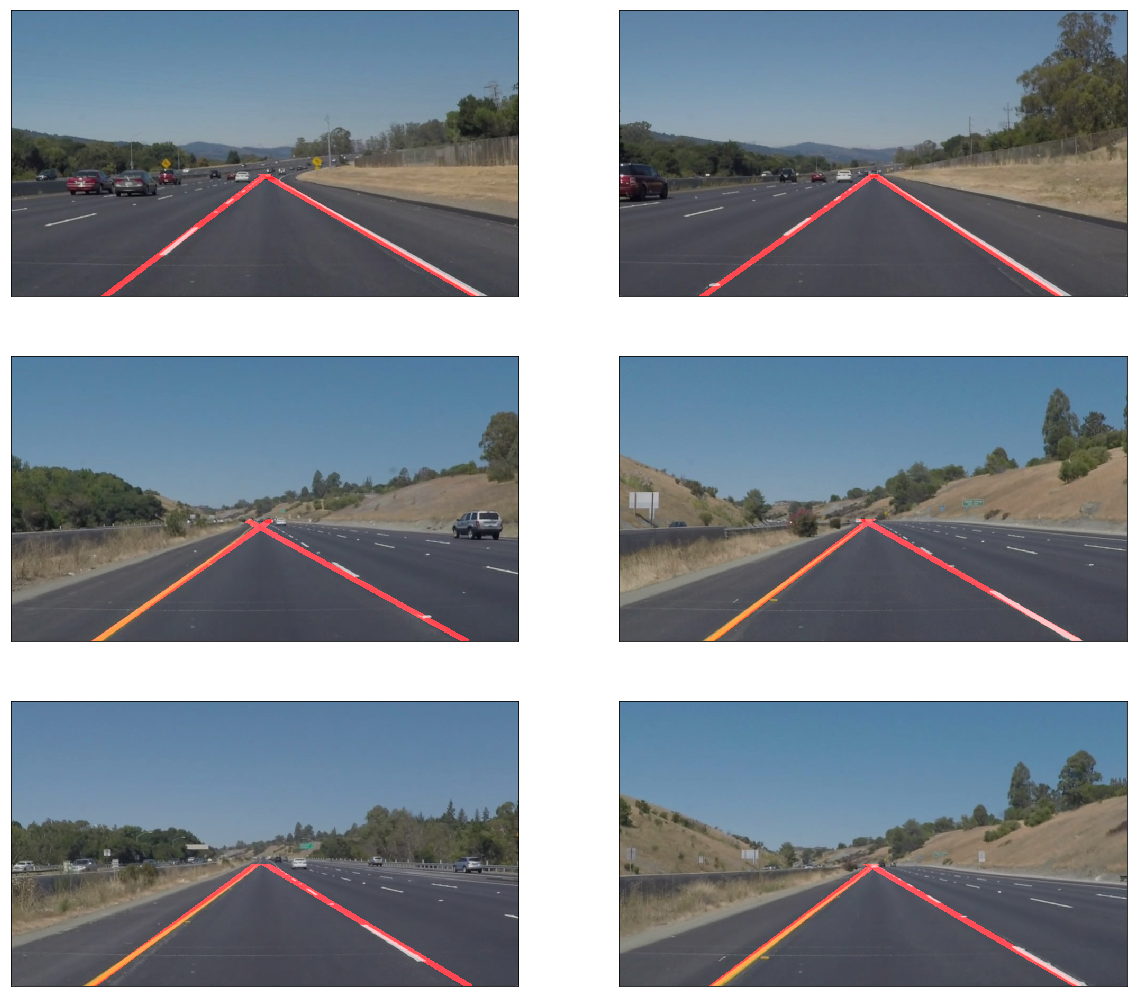

In [15]:
plot_images(output_images)